In [86]:
import pandas as pd
import CellLayers
import plotly
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import plotly.graph_objects as go

# Cell Layers- PBMC Tutorial

## Import Expression, Meta, Cluster Modularity, and Silhouette Score Data

In [2]:
exp_df = pd.read_csv('../Data/PBMC/PBMC_exp.csv',index_col=[0])
meta_df = pd.read_csv('../Data/PBMC/PBMC_meta.csv',index_col=[0])
mod_df = pd.read_csv('../Data/PBMC/pbmc_modularity.csv',index_col=[0])
sil_df = pd.read_csv('../Data/PBMC/pbmc_silhouette_scores.csv', index_col=[0])

In [3]:
exp_df.head()

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2.1,SRSF10.1
AAACATACAACCAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,3.745718,1.635873,0.0,2.864242,0.0,0.000000,0.0,0.0,0.0
AAACATTGAGCTAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,4.223994,1.111715,0.0,2.851662,0.0,1.111715,0.0,0.0,0.0
AAACATTGATCAGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.354503,1.995416,0.0,2.618163,0.0,0.000000,0.0,0.0,0.0
AAACCGTGCTTCCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.566387,2.515108,2.149274,0.0,2.149274,0.0,0.000000,0.0,0.0,0.0
AAACCGTGTATGCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,3.063772,0.0,2.416278,0.0,0.000000,0.0,0.0,0.0


In [4]:
meta_df.head()

,res.0.1,res.0.2,res.0.3,res.0.4,res.0.5
AAACATACAACCAC,0,0,0,2,1
AAACATTGAGCTAC,3,3,3,3,3
AAACATTGATCAGC,0,0,0,2,1
AAACCGTGCTTCCG,1,1,1,1,2
AAACCGTGTATGCG,2,2,2,6,6


In [5]:
mod_df.head()

,resolution,modularity
1,res.0.1,0.9625
2,res.0.2,0.9348
3,res.0.3,0.9092
4,res.0.4,0.8884
5,res.0.5,0.8720


In [6]:
sil_df.head()

,res,sil
1,res.0.1_0,0.316572
2,res.0.1_1,0.218829
3,res.0.1_2,0.011805
4,res.0.1_3,0.246195
5,res.0.2_0,0.316926


# Figure 1 A

In [163]:
sankey_fig, sankey_dict = CellLayers.run(exp_df, 
                                         meta_df,
                                         modularity=mod_df,
                                         silhouette=sil_df, genes=['CD3E'])

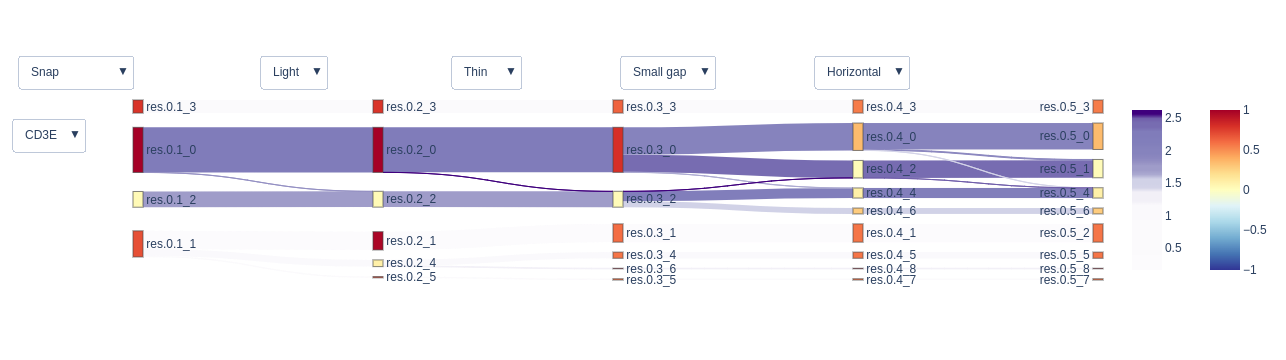

In [147]:
sankey_fig.show()

In [10]:
plotly.offline.plot(sankey_fig, filename='PBMC_tutorial.html') # export to html file

'PBMC_tutorial.html'

# Figure 1 B

## Import GSEA Data

In [164]:
class EnrichmentSankey:
    def __init__(self, 
                 sankey_dict,
                 genset_oi,
                 enrichment_df,
                 leading_edge
                ):
        """
        Keyword arguments:
        - sankey_dict
        - geneset_oi
        - enrichment_df
        - leading_edge
        """
        self.sankey_dict = sankey_dict
        self.geneset_oi = geneset_oi
        self.enrichment_df = enrichment_df
        self.leading_edge = leading_edge
        
    def _create_enrichment_dict(self):
        """
        """
        # Retrieve geneset(s) of interest's enrichment scores across multi-resolutions
        enrichment_dict = {} # keys are the geneset name and values are the multi-resolution enrichment scores
        for geneset in self.geneset_oi:
            enrichment_dict[geneset] = self.enrichment_df.loc[self.enrichment_df['gene.set']== geneset, ['res_cluster', 'combined.score']]
        return enrichment_dict

    def _add_enrichment(self, enrichment_dict):
        """
        Parameters
        ----------
        enrichment_dict : dict
        """
        for geneset_name, geneset_df in enrichment_dict.items():
            geneset_df = geneset_df.rename(columns = {'combined.score':geneset_name+'_combined.score'})
            self.sankey_dict['node_data'] = pd.merge(self.sankey_dict['node_data'],
                                                     geneset_df,
                                                     left_on='node_labels',
                                                     right_on='res_cluster')
            norm = matplotlib.colors.Normalize(vmin=min(self.sankey_dict['node_data'][geneset_name+'_combined.score']),
                                               vmax=max(self.sankey_dict['node_data'][geneset_name+'_combined.score']),
                                               clip=False)
            mapper = cm.ScalarMappable(norm=norm, cmap=cm.YlGn)
            sankey_dict['node_data'][geneset_name+'_hex'] = [mcolors.to_hex(mapper.to_rgba(mapper_color)) 
                                                             for mapper_color in self.sankey_dict['node_data'][geneset_name+'_combined.score'].tolist()]
        self.sankey_dict['node_data'] = pd.merge(self.sankey_dict['node_data'],
                                                 self.leading_edge,
                                                 left_on='node_labels',
                                                 right_on='res_cluster')
        del self.sankey_dict['node_data']['res_cluster_x']
        del self.sankey_dict['node_data']['res_cluster_y']

    def run(self):
        enrichment_dict = self._create_enrichment_dict()
        self._add_enrichment(enrichment_dict)
        return sankey_fig, sankey_dict

In [ ]:
class BuildEnrichmentSankey:
    def __init__(self, 
                 sankey_dict):
        self.sankey_dict = sankey_dict
    def run():
        

In [165]:
# Import data
pbmc_gsea = pd.read_csv('../Data/PBMC/pbmc_gsea.csv', index_col=[0])
pbmc_leading_edge_genes = pd.read_csv('../Data/PBMC/pbmc_top_genes.csv', index_col=[0])

# Create a list of your gene set(s) of interest
geneset_oi = ['antigen processing and presentation of exogenous peptide antigen via MHC class II (GO:0019886)',
              'antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independent (GO:0002480)']



In [166]:
sankey_fig, sankey_dict = EnrichmentSankey(sankey_dict,
                                           geneset_oi,
                                           pbmc_gsea,
                                           pbmc_leading_edge_genes).run()

In [128]:
gsea_dict = {} # keys are the geneset name and values are the multi-resolution enrichment scores
for geneset in geneset_oi:
    gsea_dict[geneset] = pbmc_gsea.loc[pbmc_gsea['gene.set']== geneset, ['res_cluster', 'combined.score']]

In [129]:
# Add gsea data to sankey_dict['node_data']
for geneset_name, geneset_df in gsea_dict.items():
    geneset_df = geneset_df.rename(columns = {'combined.score':geneset_name+'_combined.score'})
    sankey_dict['node_data'] = pd.mergsankey_dicte(sankey_dict['node_data'], 
                                        geneset_df, 
                                        left_on='node_labels', 
                                        right_on='res_cluster')
    norm = matplotlib.colors.Normalize(vmin=min(sankey_dict['node_data'][geneset_name+'_combined.score']),
                                       vmax=max(sankey_dict['node_data'][geneset_name+'_combined.score']),
                                       clip=False)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.YlGn)
    sankey_dict['node_data'][geneset_name+'_hex'] = [mcolors.to_hex(mapper.to_rgba(mapper_color)) 
                                                     for mapper_color in sankey_dict['node_data'][geneset_name+'_combined.score'].tolist()]
    
sankey_dict['node_data'] = pd.merge(sankey_dict['node_data'], 
                                    pbmc_leading_edge_genes,
                                    left_on='node_labels', right_on='res_cluster')
del sankey_dict['node_data']['res_cluster_x']
del sankey_dict['node_data']['res_cluster_y']

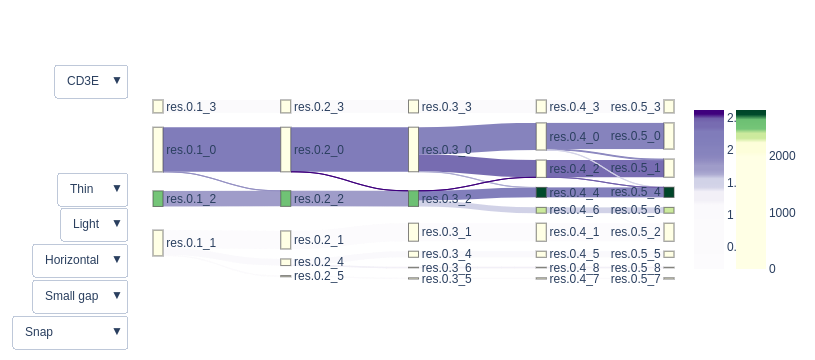

In [133]:
starter_gene = 'CD3E'
gene_set = 'antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independent (GO:0002480)'

# Create node label
label_list = []
for data in sankey_dict['node_data'][['modularity', 'silhoutte_score', gene_set + '_combined.score', 'top_genes']].values:
    label = '<br />' + gene_set + '<br />' + 'Gene Set Score: ' + str(data[2]) + '<br />' + 'Top Genes: ' + str(data[-1])
    label_list.append(label)
sankey_dict['node_data']['label'] = label_list

fig = go.Figure(data=[dict(type='sankey', orientation='h', 
                           node = dict(pad = 10, thickness=10,
                                       label=sankey_dict['node_data']['node_labels'],
                                       customdata = sankey_dict['node_data']['label'],
                                       hovertemplate= '%{customdata}',
                                       color = sankey_dict['node_data'][gene_set + '_hex']),
                           link = dict(source = sankey_dict['data']['source'],
                                       target = sankey_dict['data']['target'],
                                       color = sankey_dict['data'][starter_gene+'_hex'],
                                       value = sankey_dict['data']['value']))])

fig.add_trace(go.Scatter(x=[None],
                         y=[None],
                         mode='markers',
                         visible=True,
                         marker=sankey_dict['exp_colorbar'][starter_gene]))

fig.add_trace(go.Scatter(x=[None],
                         y=[None],
                         mode='markers',
                         visible=True,
                         marker={'colorscale':sankey_dict['node_data'][[gene_set + '_combined.score', gene_set+'_hex']].sort_values(gene_set + '_combined.score')[gene_set+'_hex'].tolist(), 
                                 'showscale':True, 
                                 'cmin':min(pbmc_gsea[pbmc_gsea['gene.set'].isin(['antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independent (GO:0002480)'])]['combined.score'].tolist()),
                                 'cmax':max(pbmc_gsea[pbmc_gsea['gene.set'].isin(['antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independent (GO:0002480)'])]['combined.score'].tolist()), 
                                 'colorbar': {'x':1.1}}))

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the xticks
fig['layout']['showlegend'] = False
fig['layout']['xaxis']['showgrid'] = False
fig['layout']['yaxis']['showgrid'] = False
fig.update_layout(xaxis_zeroline=False, yaxis_zeroline=False)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

fig.update_layout(
    updatemenus=[dict(y=1.2, 
                      buttons=[dict(label=starter_gene, method='relayout', args=['paper_bgcolor', 'white']),
                               dict(label='Dark', method='relayout', args=['paper_bgcolor', 'black'])]),
                 # dict(y=1, 
                 #      buttons=[dict(label='Silhouette', method='relayout', args=['paper_bgcolor', 'white']),
                 #               dict(label='Dark', method='relayout', args=['paper_bgcolor', 'black'])]),
                 # dict(y=0.8,
                 #      buttons=[dict(label='GO:0002480', method='restyle',args=['node.thickness', 8]),
                 #               dict(label='Thick',method='restyle',args=['node.thickness', 15])]),
                 dict(y=0.6,
                      buttons=[dict(label='Thin', method='restyle',args=['node.thickness', 8]),
                               dict(label='Thick',method='restyle',args=['node.thickness', 15])]),
                 dict(y=-0.2,
                      buttons=[dict(label='Snap',method='restyle', args=['arrangement', 'snap']),
                               dict(label='Perpendicular', method='restyle',args=['arrangement', 'perpendicular']),
                               dict(label='Freeform', method='restyle',args=['arrangement', 'freeform']),
                               dict(label='Fixed', method='restyle',args=['arrangement', 'fixed'])]),
                 dict(y=0,
                      buttons=[dict(label='Small gap',method='restyle',args=['node.pad', 15]),
                               dict(label='Large gap',method='restyle',args=['node.pad', 20])]),
                 dict(y=0.2,
                      buttons=[dict(label='Horizontal', method='restyle', args=['orientation', 'h']),
                               dict(label='Vertical',method='restyle',args=['orientation', 'v'])]),
                 dict(y=0.4,
                      buttons=[dict(label='Light', method='relayout', args=['paper_bgcolor', 'white']),
                               dict(label='Dark', method='relayout', args=['paper_bgcolor', 'black'])])])
fig.show()